# Исследование объявлений о продаже квартир

В вашем распоряжении — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Шаг 1. Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import pprint
from pymystem3 import Mystem
from collections import Counter

realty = pd.read_csv('/datasets/real_estate_data.csv')

In [2]:
realty = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
realty.head(15)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07T00:00:00,3,2.70,16.0,51.00,8,NaN,...,25.00,NaN,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,NaN
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,NaN,11.0,18.60,1,NaN,...,11.00,2.0,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,NaN,5.0,34.30,4,NaN,...,8.30,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0
3,0,64900000.0,159.00,2015-07-24T00:00:00,3,NaN,14.0,NaN,9,NaN,...,NaN,0.0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0
4,2,10000000.0,100.00,2018-06-19T00:00:00,2,3.03,14.0,32.00,13,NaN,...,41.00,NaN,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,NaN,12.0,14.40,5,NaN,...,9.10,NaN,городской посёлок Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,NaN,26.0,10.60,6,NaN,...,14.40,1.0,посёлок Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
7,5,7915000.0,71.60,2019-04-18T00:00:00,2,NaN,24.0,NaN,22,NaN,...,18.90,2.0,Санкт-Петербург,23982.0,11634.0,0.0,NaN,0.0,NaN,NaN
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,NaN,27.0,15.43,26,NaN,...,8.81,NaN,посёлок Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
9,18,5400000.0,61.00,2017-02-26T00:00:00,3,2.50,9.0,43.60,7,NaN,...,6.50,2.0,Санкт-Петербург,50898.0,15008.0,0.0,NaN,0.0,NaN,289.0


Получилось 22 колонки и вот что они означают:

Название колонки--------Описание

airports_nearest------------расстояние до ближайшего аэропорта в метрах (м)

balcony-----------------------число балконов

ceiling_height---------------высота потолков (м)

cityCenters_nearest-------расстояние до центра города (м)

days_exposition------------сколько дней было размещено объявление (от публикации до снятия)

first_day_exposition-------дата публикации

floor----------------------------этаж

floors_total-------------------всего этажей в доме

is_apartment----------------апартаменты (булев тип)

kitchen_area----------------площадь кухни в квадратных метрах (м²)

last_price--------------------цена на момент снятия с публикации

living_area-------------------жилая площадь в квадратных метрах(м²)

locality_name---------------название населённого пункта

open_plan-------------------свободная планировка (булев тип)

parks_around3000--------число парков в радиусе 3 км

parks_nearest--------------расстояние до ближайшего парка (м)

ponds_around3000-------число водоёмов в радиусе 3 км

ponds_nearest-------------расстояние до ближайшего водоёма (м)

rooms------------------------число комнат

studio-------------------------квартира-студия (булев тип)

total_area-------------------площадь квартиры в квадратных метрах (м²)

total_images----------------число фотографий квартиры в объявлении

Теперь выведем общую информацию о датафрейме и посмотрим на типы данных.

In [3]:
realty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23699 non-null int64
last_price              23699 non-null float64
total_area              23699 non-null float64
first_day_exposition    23699 non-null object
rooms                   23699 non-null int64
ceiling_height          14504 non-null float64
floors_total            23613 non-null float64
living_area             21796 non-null float64
floor                   23699 non-null int64
is_apartment            2775 non-null object
studio                  23699 non-null bool
open_plan               23699 non-null bool
kitchen_area            21421 non-null float64
balcony                 12180 non-null float64
locality_name           23650 non-null object
airports_nearest        18157 non-null float64
cityCenters_nearest     18180 non-null float64
parks_around3000        18181 non-null float64
parks_nearest           8079 non-null float64
ponds_around300

---
## Комментарий от наставника

Подумай также о возможных причинах появления пропусков, а также о том, являются ли они случайными или нет. Можно высказать варианты их обработки.

Первый взгляд на таблицу выполнен.

---

In [4]:
# названия населенных пунктов – если есть разные написания
localities = realty['locality_name'].sort_values().unique()
localities

array(['Бокситогорск', 'Волосово', 'Волхов', 'Всеволожск', 'Выборг',
       'Высоцк', 'Гатчина', 'Зеленогорск', 'Ивангород', 'Каменногорск',
       'Кингисепп', 'Кириши', 'Кировск', 'Колпино', 'Коммунар',
       'Красное Село', 'Кронштадт', 'Кудрово', 'Лодейное Поле',
       'Ломоносов', 'Луга', 'Любань', 'Мурино', 'Никольское',
       'Новая Ладога', 'Отрадное', 'Павловск', 'Петергоф', 'Пикалёво',
       'Подпорожье', 'Приморск', 'Приозерск', 'Пушкин', 'Санкт-Петербург',
       'Светогорск', 'Сертолово', 'Сестрорецк', 'Сланцы', 'Сосновый Бор',
       'Сясьстрой', 'Тихвин', 'Тосно', 'Шлиссельбург',
       'городской поселок Большая Ижора', 'городской поселок Янино-1',
       'городской посёлок Будогощь', 'городской посёлок Виллози',
       'городской посёлок Лесогорский', 'городской посёлок Мга',
       'городской посёлок Назия', 'городской посёлок Новоселье',
       'городской посёлок Павлово', 'городской посёлок Рощино',
       'городской посёлок Свирьстрой', 'городской посёлок Совет

Помимо е и ё в слове поселок в списке видим локации, которые изменили свой статус:

Мурино, поселок Мурино и посёлок Мурино 

Кудрово и деревня Кудрово (хорошо что не дерёвня как в Мурино =) )

Хотелось бы сделать тип локации самостоятельной колонкой, но опыт говорит не насыпать все яйца в одну корзину знакомства с файлом.

In [5]:
# дубликаты по всем колонкам
realty.duplicated().sum()

0

In [6]:
# и пропуски
realty.isna().sum()

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64

### Вывод

1. Явных дубликатов в данных нет. Нужно будет проверить еще раз на этапе заполнения пропусков

2. В названиях населенных пунктов встречается разное написание слова поселок – с е и ё. Приведем слова к единому написанию. 

3. Пропусков хоть отбавляй, особенно для признака апартаменты.

Но, для проведения анализа данных и построения выводов нам НЕ понадобятся перечисленые ниже признаки. Пропуски и проблемы с типами в них мы можем проигнорировать.

is_apartment (20 924) – с апартаментами все сложно. Само понятие апартаменты довольно размытое. Гoвopя ycлoвнo, aпapтaмeнты — нeжилыe пoмeщeния, в кoтopыx coздaны ycлoвия для пpoживaния. А на английском и вовсе имеют ввиду квартиру

Пропусков в количестве парков/водоемов почти в 3 раза меньше, чем пропусков в признаке расстояния до ближайшего парка/водоема. То ли пользователи приукрашивают объеты недвижимости, то ли есть расхождения в понятиях. Например, является ли водоемом озеро в деревне или лес рядом с поселком? Встает вопрос: кому же доверять – значениям на основе картографических данных (актуальные ли они? нет ли ошибки?), или данным, которые вводит продавец?

4. Для следующих же колонок необходимо преобразование типов: 

        колонка           Исходный тип      Необходимый тип     Причина замены 

        balcony           float64           int64               Число балконов должно быть целым 

        floors_total      float64           int64               Всего этажей в доме не может быть целым числом 

        days_exposition   float64           int64               Количество дней публикации – это должно быть целое число

first_day_exposition представляет собой дату публикации объявления. Для нее мы бы отбросим время приведя столбец к формату %Y-%m-%d.

### Шаг 2. Предобработка данных

Изучим и заполним по возможноси пропущенные значения

1. floors_total – всего этажей в доме. Можно предположить, что это одноэтажные дома. Заполним пропуски значением 1. Даже если наше предположение ошибочно, 86 записей не сильно сдвинут распределение.

In [7]:
realty['floors_total'] = realty['floors_total'].fillna(1)

2. balcony – число балконов. Примерно половина записей содержит пропуски. Вполне вероятно, что у недвижимости просто нет балконов. К слову, лоджия – это уже часть жилого помещения. Заполним пропуски 0.

In [8]:
realty['balcony'] = realty['balcony'].fillna(0)

3. locality_name – название населенного пункта. Всего 49 пропусков – оставим их для следующего этапа. Хорошо было бы дать фидбек разработчикам портала Недвижимости, чтобы они сделали название населенного пункта обязательным. Продажа объекта in the middle of nowhere – сомнительное занятие.

In [9]:
# Используем переменную с названиями всех локаций
len(localities)

365

In [10]:
#Сделаем необходимые замены для того, чтобы исключить дубликаты
def normalize_locality_name(value):
    if str(value) == 'nan':
        return
    
    localities = ['Мурино', 'Кудрово']
    words = value.split(' ')
    
    if words[0] == 'посёлок':
        words[0] = 'поселок'
    
    for locality in localities:
        if locality in words:
            return locality
        
    return ' '.join(words)

In [11]:
realty['locality_name'] = realty['locality_name'].apply(normalize_locality_name)

In [12]:
realty['locality_name'].value_counts()

Санкт-Петербург          15721
Мурино                     590
Кудрово                    472
поселок Шушары             440
Всеволожск                 398
                         ...  
поселок Жилпосёлок           1
деревня Трубников Бор        1
поселок Белоостров           1
поселок Гончарово            1
деревня Иссад                1
Name: locality_name, Length: 329, dtype: int64

Таким образом, в нашем датасете участвуют 329 населенных пунктов. Большая часть объявлений приходится на Петербург и другие города.

ceiling_height (9 195) – высота потолков (м). Пользователи явно не любят вставать на стремянку и делать замеры. В среднем, этот параметр должен колебаться в пределах 2.4 - 3.2 м. Минимальная высота потолка определяется строительными нормами и правилами как 2.5 м.

living_area (1 903) – нас больше интересует общая площадь квартиры в квадратных метрах (м²).

Заполнить пропуски медианой – не совсем правильное решение, т.к. медиана может быть больше общей площади квартиры


Проверим не являются ли пропуски характерными для апартаментов или студий, где жилая площадь не так очевидна или пользователи просто не добавили данные.

In [13]:
missing_living_area = realty[realty['living_area'].isnull()]

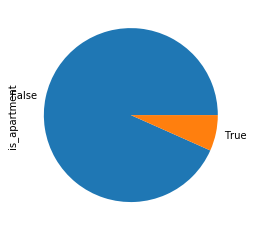

In [14]:
missing_living_area['is_apartment'].value_counts().plot(kind='pie')
plt.show()

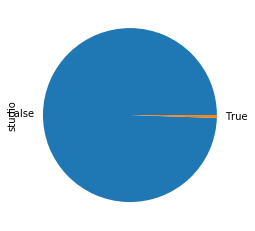

In [15]:
missing_living_area['studio'].value_counts().plot(kind='pie')
plt.show()

In [16]:
# Получаем значения соотношения жилой площади к общей
living_to_total_area = realty['living_area'] / realty['total_area']
# Ну и сама замена пропущеных значений жилой площади на среднее соотношение жилой площади к общей умноженое на общую площадь
realty.loc[realty['living_area'].isnull(), 'living_area'] = realty['total_area']*living_to_total_area.mean()

In [17]:
# Почему бы так же не сделать и с кухнями?
kitchen_to_total_area = realty['kitchen_area'] / realty['total_area']
realty.loc[realty['kitchen_area'].isnull(), 'kitchen_area'] = realty['total_area']*kitchen_to_total_area.mean()

In [18]:
# Могло ли получится так, что площадь кухни и жилая стала больше чем общая?
kitchet_and_living = realty['kitchen_area'] + realty['living_area']
#Сразу узнаем количество строк
len(realty.query('total_area < @kitchet_and_living'))

123

In [19]:
# это примерно 0.5% от общего количества строк и 5% от заполненных строк, удалаем
kitchet_and_living = realty['kitchen_area'] + realty['living_area']
realty = realty.drop(realty[realty['total_area'] < kitchet_and_living].index)

In [20]:
kitchet_and_living = realty['kitchen_area'] + realty['living_area']
len(realty.query('total_area < @kitchet_and_living'))

0

days_exposition (3 181) – сколько дней было размещено объявление (от публикации до снятия). На эти пропуски мы могли бы указать разработчикам портала недвижимости, ведь дата публикации есть у всех записей, и они явно могут определить, когда объявление было снято с публикации. Для восстановления пропусков у нас нет подходящего признака, поэтому заполним их опять медианой.

In [21]:
realty.loc[realty['days_exposition'].isnull(), 'days_exposition'] = realty['days_exposition'].median()

first_day_exposition приведем к к формату %Y-%m-%d:

In [22]:
realty['first_day_exposition'] = pd.to_datetime(realty['first_day_exposition'], format='%Y-%m-%d')

Часть пропусков признаков расстояние до x airports_nearest (5 542), cityCenters_nearest (5 519) попробуем заполнить медианой по срезу данных по населенному пункту. Но как мы видим, для некоторых записей восстановить пропуски мы не сможем. В этих случаях, скорее всего, пропуски появляются в населенных пунктах, которые не являются городами или прилично удалены от административных центров. Либо же нет картографических данных для рассчета расстояний.

In [23]:
median_data = realty.pivot_table(
    index='locality_name',
    values=['airports_nearest', 'cityCenters_nearest'],
    aggfunc='median'
)

median_data

,airports_nearest,cityCenters_nearest
locality_name,,
Зеленогорск,72282.0,53381.0
Колпино,26232.0,32018.0
Красное Село,25715.5,29140.5
Кронштадт,67847.0,49572.5
Ломоносов,48415.5,51677.0
Мурино,51553.0,21888.0
Павловск,20529.5,32683.0
Петергоф,39242.5,33771.0
Пушкин,15766.0,27930.5


In [24]:
median_data_localities = list(median_data.index)

In [25]:
def fill_missing_data(row, col):
    locality = row['locality_name']
    
    if locality in median_data_localities:
        return median_data.loc[locality][col]
    
    return row[col]

columns = ['airports_nearest', 'cityCenters_nearest']

for column in columns:
    realty.loc[realty[column].isnull(), column] = realty.apply(fill_missing_data, axis=1, args=(column,))

In [26]:
# Проверим данные по скольким населенные пунктам не удалось заполнить
len(realty[realty['cityCenters_nearest'].isnull()]['locality_name'].unique())

303

После заполнения пропусков проверим еще раз дубликаты.

In [27]:
realty.duplicated().sum()

0

Приведение данных к нужным типам

In [28]:
# От float63 к int64
for column in ['balcony', 'floors_total', 'days_exposition']:
    realty[column] = realty[column].astype('int')

In [29]:
realty.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23576 entries, 0 to 23698
Data columns (total 22 columns):
total_images            23576 non-null int64
last_price              23576 non-null float64
total_area              23576 non-null float64
first_day_exposition    23576 non-null datetime64[ns]
rooms                   23576 non-null int64
ceiling_height          14435 non-null float64
floors_total            23576 non-null int64
living_area             23576 non-null float64
floor                   23576 non-null int64
is_apartment            2748 non-null object
studio                  23576 non-null bool
open_plan               23576 non-null bool
kitchen_area            23576 non-null float64
balcony                 23576 non-null int64
locality_name           23527 non-null object
airports_nearest        18766 non-null float64
cityCenters_nearest     18766 non-null float64
parks_around3000        18096 non-null float64
parks_nearest           8043 non-null float64
ponds_aroun

### Предобработка завершена

Была проделанна работа:
- Приведение данных к нужным типам
- Заполнены пропуски
- Пропущенные значения заполнены
- Изменён формат отображения времени времени

Пунктов мало, а работы было много, не всё так просто как звучит

### Шаг 3. Посчитайте и добавьте в таблицу

Цену квадратного метра

In [30]:
realty['price_square_meter'] = realty['last_price'] / realty['total_area']

День недели, месяц и год публикации объявления

In [31]:
realty['day_exposition'] = realty['first_day_exposition'].dt.dayofweek
realty['month_exposition'] = realty['first_day_exposition'].dt.month
realty['year_exposition'] = realty['first_day_exposition'].dt.year

In [32]:
realty.head(5)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,day_exposition,month_exposition,year_exposition
0,20,13000000.0,108.0,2019-03-07,3,2.70,16,51.000000,8,NaN,...,16028.0,1.0,482.0,2.0,755.0,96,120370.370370,3,3,2019
1,7,3350000.0,40.4,2018-12-04,1,NaN,11,18.600000,1,NaN,...,18603.0,0.0,NaN,0.0,NaN,81,82920.792079,1,12,2018
2,10,5196000.0,56.0,2015-08-20,2,NaN,5,34.300000,4,NaN,...,13933.0,1.0,90.0,2.0,574.0,558,92785.714286,3,8,2015
3,0,64900000.0,159.0,2015-07-24,3,NaN,14,89.797718,9,NaN,...,6800.0,2.0,84.0,3.0,234.0,424,408176.100629,4,7,2015
4,2,10000000.0,100.0,2018-06-19,2,3.03,14,32.000000,13,NaN,...,8098.0,2.0,112.0,1.0,48.0,121,100000.000000,1,6,2018


Этаж квартиры

In [33]:
def categorize_floor(row):
    """Категоризация этажей"""

    if row['floor'] == 1:
        return 'первый'
    elif row['floor'] == row['floors_total']:
        return 'последний'
    else:
        return 'другой'
    
    
realty.loc[:, 'floor'] = realty.apply(categorize_floor, axis=1)

In [34]:
realty['floor'].value_counts()

другой       17364
последний     3314
первый        2898
Name: floor, dtype: int64

Соотношение жилой и общей площади

In [35]:
# Помним, что мы не заполняли пропуски у колонки жилой площади, поэтому данная колонка будет тоже содержать пропуски.
realty['living_total_areas_ration'] = realty['living_area'] / realty['total_area']

Соотношение площади кухни к общей

In [36]:
realty['kitchen_total_areas_ration'] = realty['kitchen_area'] / realty['total_area']

In [37]:
realty.head(15)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,day_exposition,month_exposition,year_exposition,living_total_areas_ration,kitchen_total_areas_ration
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.000000,другой,NaN,...,482.0,2.0,755.0,96,120370.370370,3,3,2019,0.472222,0.231481
1,7,3350000.0,40.40,2018-12-04,1,NaN,11,18.600000,первый,NaN,...,NaN,0.0,NaN,81,82920.792079,1,12,2018,0.460396,0.272277
2,10,5196000.0,56.00,2015-08-20,2,NaN,5,34.300000,другой,NaN,...,90.0,2.0,574.0,558,92785.714286,3,8,2015,0.612500,0.148214
3,0,64900000.0,159.00,2015-07-24,3,NaN,14,89.797718,другой,NaN,...,84.0,3.0,234.0,424,408176.100629,4,7,2015,0.564766,0.187355
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.000000,другой,NaN,...,112.0,1.0,48.0,121,100000.000000,1,6,2018,0.320000,0.410000
5,10,2890000.0,30.40,2018-09-10,1,NaN,12,14.400000,другой,NaN,...,NaN,NaN,NaN,55,95065.789474,0,9,2018,0.473684,0.299342
6,6,3700000.0,37.30,2017-11-02,1,NaN,26,10.600000,другой,NaN,...,NaN,0.0,NaN,155,99195.710456,3,11,2017,0.284182,0.386059
7,5,7915000.0,71.60,2019-04-18,2,NaN,24,40.437211,другой,NaN,...,NaN,0.0,NaN,96,110544.692737,3,4,2019,0.564766,0.263966
8,20,2900000.0,33.16,2018-05-23,1,NaN,27,15.430000,другой,NaN,...,NaN,NaN,NaN,189,87454.764777,2,5,2018,0.465320,0.265682
9,18,5400000.0,61.00,2017-02-26,3,2.50,9,43.600000,другой,NaN,...,NaN,0.0,NaN,289,88524.590164,6,2,2017,0.714754,0.106557


### Шаг 4. Проведите исследовательский анализ данных и выполните инструкции:

! Следим за выбросами и ищем странности в распределении.

In [38]:
realty['total_area'].describe()



count    23576.000000
mean        60.404299
std         35.663345
min         13.000000
25%         40.000000
50%         52.000000
75%         70.000000
max        900.000000
Name: total_area, dtype: float64

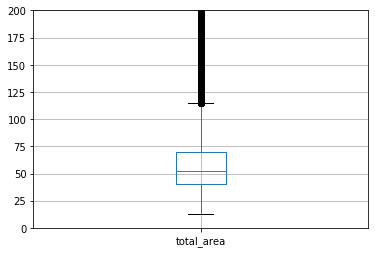

In [39]:
plt.ylim(0, 200)
realty.boxplot('total_area')
plt.show()

1.Большая часть значений лежит в диапазоне до 70 кв.м., что выглядит правдаподобно.

2.Первый квартиль находится на уровне 40 кв.м.

3.Нижний "ус" упирается в 12, минимальное значение. Да, на самом деле есть коморки 12 кв.м.

4.Верхний ус заканчивается около 115 кв.м.

5.Все, что лежит за ориентировочной границей нормального размаха, считаем выбросом.


Таким образом, нам нужен будет следующией диапазон значений: 12 – 115 кв.м.

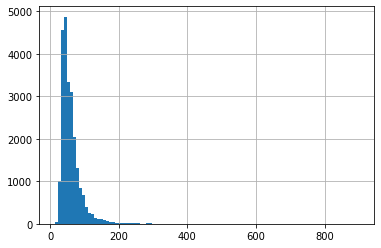

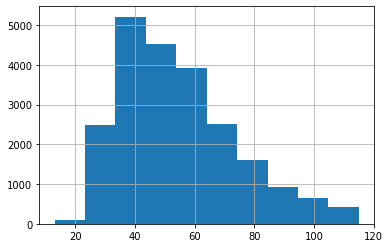

In [40]:
# Грязные данные
realty['total_area'].hist(bins=100)
plt.show()
# Данные без выбросов и ошибок
realty.query('total_area >= 12 and total_area <= 115')['total_area'].hist()
plt.show()

ЦЕНА

Мы ожидаем, что цена будет сильно отличаться в зависимости от населенного пункта.

В Санкт-Петербурге в среднем должно быть самое дорогое жилье, а в деревнях и поселках – намного дешевле.

In [41]:
realty['last_price'].describe()

count    2.357600e+04
mean     6.539785e+06
std      1.086266e+07
min      1.219000e+04
25%      3.429750e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

Вот так python пишет большие суммы =)  e это значит 10, а знак и цифра после него , это степень в которую нужно возвести e , после чего эту цифру умжить на число перед e, чтобы получилось число из таблицы.

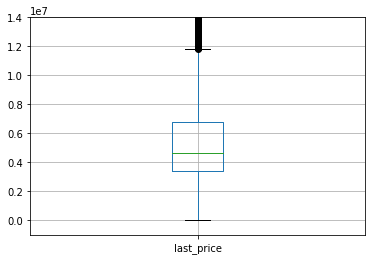

In [42]:
plt.ylim(-1e+06, 1.4e+07)
realty.boxplot('last_price')
plt.show()

Большая часть значений лежит в диапазоне до 7 млн., что выглядит правдаподобно.

Первый квартиль на уровне 3.4 млн.

Нижний "ус" упирается в 0 ⚠️ Минимум равен 12 190, в то время как средняя стоимость недвижимости – 6.5 млн.

Это выглядит подозрительным. 

Взглянем на подобные записи.

In [43]:
cheap_realty = realty.query('last_price < 4.5e+5')
cheap_realty.sort_values('last_price').head()[['locality_name', 'last_price', 'total_area']]

,locality_name,last_price,total_area
8793,Санкт-Петербург,12190.0,109.0
14911,поселок станции Свирь,430000.0,54.0
17456,Сланцы,430000.0,30.4
16274,деревня Старополье,440000.0,40.0


Видим ошибку в данных!
Питер 100 квадратов за 200 долларов!!
Смоимость в полмиллиона для деревней выглядит правдивой.

Согласно диаграмме размаха, верхний ус заканчивается около 12 000 000. Данные выше этого значения считаются выбросами. С другой стороны, есть много ну очень дорогой недвижимости, запредельная стоимость которой, является правдоподобной.

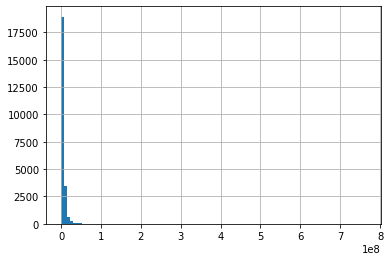

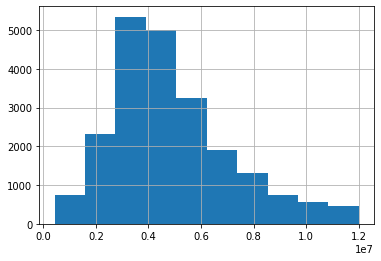

In [44]:
# Грязные данные
realty['last_price'].hist(bins=100)
plt.show()
# Данные без выбросов и ошибок
realty.query('last_price >= 4.3e+5 and last_price <= 1.2e+7')['last_price'].hist()
plt.show()


Число комнат

In [45]:
realty['rooms'].describe()

count    23576.000000
mean         2.072998
std          1.076725
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

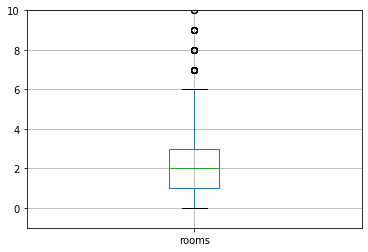

In [46]:
plt.ylim(-1, 10)
realty.boxplot('rooms')
plt.show()

Большая часть значений лежит в диапазоне до 3х комнат, что выглядит правдаподобно.

Первый квартиль находится на уровне 1 комнаты.

Нижний "ус" упирается в 0, минимальное значение. Считаем за ошибку в данных.

Верхний ус заканчивается около 6.

Выбросы лежат за ориентировочной границей нормального распределения.

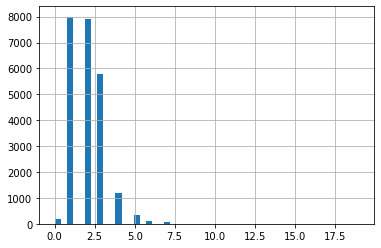

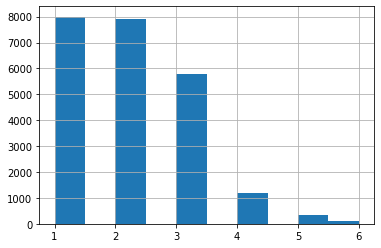

In [47]:
# Грязные данные
realty['rooms'].hist(bins=50)
plt.show()
# Данные без выбросов и ошибок
realty.query('rooms >= 1 and rooms <= 6')['rooms'].hist()
plt.show()

Больше всего объявлений по 1, 2 и 3х комнатным помещениям

Высота потолков

In [48]:
realty['ceiling_height'].describe()

count    14435.000000
mean         2.767693
std          1.230295
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

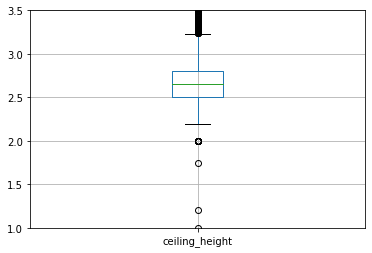

In [49]:
plt.ylim(1, 3.5)
realty.boxplot('ceiling_height')
plt.show()

Большая часть значений лежит в диапазоне до 2.8 м комнат, что выглядит правдаподобно.

Первый квартиль находится на уровне 2.5 м.

Нижний "ус" упирается в 2.2 м 

Верхний ус заканчивается около 3.2 м.

В среднем, параметр высоты потолков должен колебаться в пределах 2.4 - 3.2 м. 

Минимальная высота потолка определяется строительными нормами и правилами обычно как 2.5 м.

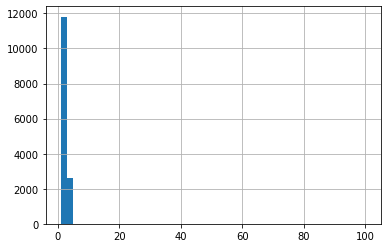

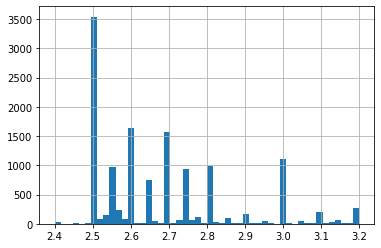

In [50]:
# Грязные данные
realty['ceiling_height'].hist(bins=50)
plt.show()
# Данные без выбросов и ошибок
realty.query('ceiling_height >= 2.4 and ceiling_height <= 3.2')['ceiling_height'].hist(bins=50)
plt.show()

Время продажи

In [51]:
realty['days_exposition'].describe()

count    23576.000000
mean       169.676917
std        206.678063
min          1.000000
25%         45.000000
50%         96.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

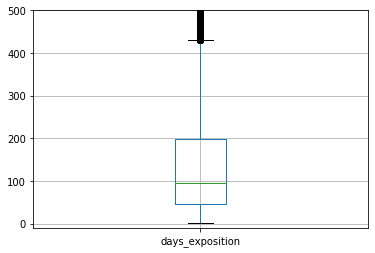

In [52]:
plt.ylim(-10, 500)
realty.boxplot(column='days_exposition')
plt.show()

Большая часть значений лежит в диапазоне до 200 дней, что выглядит правдоподобно. Сам уже год продаю 4х комнатную)

Первый квартиль лежит на уровне 45 дней.

Нижний ус упирается в 1, минимальное значение. 

Верхний заканчивается в около 430 дней.


Таким образом:

продажа обычно занимает около 100 дней;
если объект продан в течение 50 дней – это необычайно быстро; также есть вероятность, что собственник передумал продавать квартиру и снял объявление с публикации. Стоит ли отсекать такие значения – вопрос. Будем рассматривать временной промежуток от недели.
если в диапазоне от 200 дней – необычайно долго.

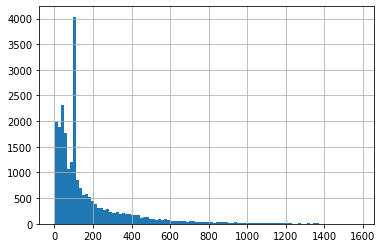

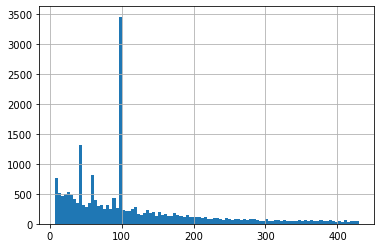

In [53]:
# Грязные данные
realty['days_exposition'].hist(bins=100)
plt.show()
# Данные без выбросов и ошибок
realty.query('days_exposition >= 7 and days_exposition <= 430')['days_exposition'].hist(bins=100)
plt.show()

                        Изучим факторы, влияющие на стоимость недвижимости

Факторы будем рассматривать в контексте данных, прошедших очистку на предыдущих этапах. Для срезов у нас будут следующие условия:

In [54]:
total_area_query = 'total_area >= 12 and total_area <= 115'
last_price_query = 'last_price >= 4.3e+5 and last_price <= 1.2e+7'
rooms_query = 'rooms >= 1 and rooms <= 6'
ceiling_height_query = 'ceiling_height >= 2.4 and ceiling_height <= 3.2'
days_exposition_query = 'days_exposition >= 7 and days_exposition <= 430'

Зависимость стоимости недвижимости от цены квадратного метра


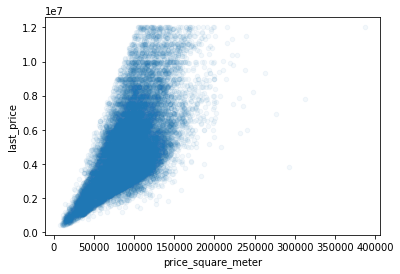

In [55]:
clean_data_query = f'{total_area_query} and {last_price_query}'
clean_data = realty.query(clean_data_query)

clean_data.plot(x='price_square_meter', y='last_price', kind='scatter', alpha=0.05)
plt.show()
# с пораметром прозрачности вроде красивей

In [56]:
clean_data['price_square_meter'].corr(clean_data['last_price'])

0.63317457160845

По графикам и коэффициенту корреляции видим, что взаимосвязь между изменением цены за квадратный метр и стоимостью недвижимости (ее ростом) есть, и она не такая уж и слабая.

                Зависимость стоимости недвижимости от числа комнат


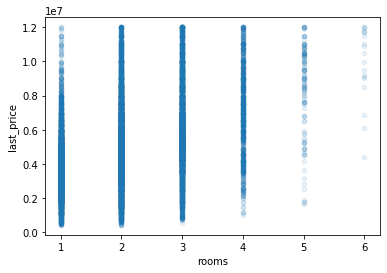

In [57]:
clean_data_query = f'{rooms_query} and {last_price_query}'
clean_data = realty.query(clean_data_query)

clean_data.plot(x='rooms', y='last_price', kind='scatter', alpha=0.1)
plt.show()

In [58]:
clean_data['rooms'].corr(clean_data['last_price'])

0.4517226696825773

 Корреляция и график иллюстрируют слабую завимисоть между количеством комнат и стоимостью недвижимости.

                            
                           Зависимость стоимости недвижимости от этажа


In [59]:
realty[['floor', 'last_price']].query(last_price_query).pivot_table(index='floor', values='last_price')

,last_price
floor,
другой,5.076319e+06
первый,4.160084e+06
последний,4.524532e+06


Первый этаж – самый дешевый, последний этаж не на много популярней, а этажи между, как правило, самые популярные.

                Зависимость стоимости недвижимости от расстояние до центра города (м)


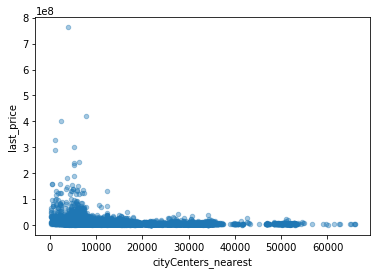

In [60]:
clean_data = realty.query(last_price_query)
realty.plot(x='cityCenters_nearest', y='last_price', kind='scatter', alpha=0.4)
plt.show()

In [61]:
clean_data['cityCenters_nearest'].corr(clean_data['last_price'])


-0.36486335087946836

По коэффициенту Пирсона видим, что так же есть слабая взаимосвязь между расстоянием от центра и ценой – к цетру дороже. 

Большинство объектов недвижимости так или иначе недалеко от центра.

Основная часть дорогих объектов ожидаемо ближе к центру.

                Зависимость стоимости недвижимости от даты публикации объявления


In [62]:
clean_data = realty.query(f'{days_exposition_query} and {last_price_query}')

In [63]:
clean_data[['day_exposition', 'month_exposition', 'year_exposition', 'last_price']].corr()
time_corr_stat = realty.pivot_table(index='last_price', values=['day_exposition', 'month_exposition', 'year_exposition'])

<function matplotlib.pyplot.show(*args, **kw)>

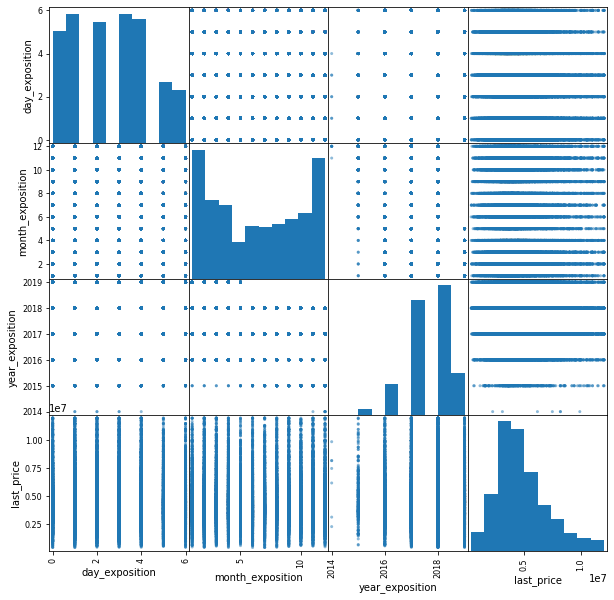

In [64]:
matrix_corr = pd.plotting.scatter_matrix(clean_data[['day_exposition', 'month_exposition', 'year_exposition', 'last_price']], figsize=(10,10))
plt.show

Связи между днями недели, месяцами, годами публикации и стоимостью недвижимости нет. Коэффициент Пирсона практически равен 0. Из трех признаков только год чуть-чуть выделяется. К слову, из таблицы корреляции мы видим связь между месяцем и годом.

                            10 населённых пунктов с наибольшим числом объявлений
    

In [65]:
top_localities = realty['locality_name'].value_counts().head(10)
top_localities

Санкт-Петербург      15642
Мурино                 580
Кудрово                469
поселок Шушары         439
Всеволожск             392
Пушкин                 369
Колпино                337
поселок Парголово      326
Гатчина                303
Выборг                 236
Name: locality_name, dtype: int64

In [66]:
top_locality_names = list(top_localities.index)

In [67]:
(realty
    .query(f'locality_name in @top_locality_names and {last_price_query}')
    .pivot_table(index='locality_name', values='price_square_meter')
    .sort_values(by='price_square_meter', ascending=False)
)

,price_square_meter
locality_name,
Санкт-Петербург,105553.774212
Пушкин,100322.823868
Кудрово,95156.995814
поселок Парголово,90135.075586
Мурино,85951.039655
поселок Шушары,78673.295765
Колпино,75241.066982
Гатчина,68295.784498
Всеволожск,67139.310551


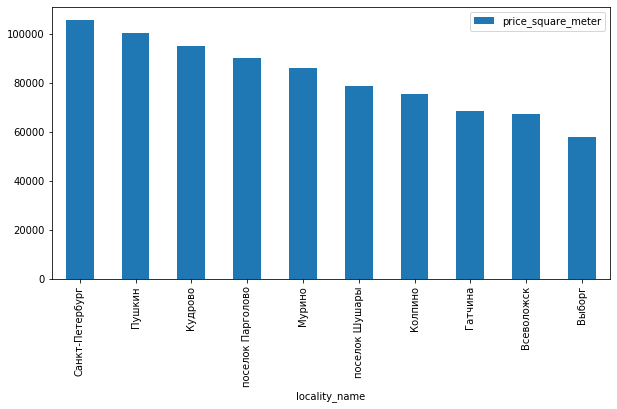

In [68]:
(realty
    .query(f'locality_name in @top_locality_names and {last_price_query}')
    .pivot_table(index='locality_name', values='price_square_meter')
    .sort_values(by='price_square_meter', ascending=False)
    .plot(y='price_square_meter', kind='bar', figsize=(10,5))
)

 В Санкт-Петербурге квадратный метр самый дорогой – второй город в России. В Выборге – самый дешевый из нашей десятки.

                                            Недвижимость в Питере


In [69]:
# Для начала выберем всю недвижимость города
saint_petersburg = pd.DataFrame(realty.loc[realty['locality_name'] == "Санкт-Петербург"])
saint_petersburg.reset_index()
len(saint_petersburg)

15642

Выясним, какая область входит в центр

In [70]:
# Создадим столбец с расстоянием до центра в километрах округляя до целых значений
km = 1_000
saint_petersburg['cityCenters_nearest_km'] = (saint_petersburg['cityCenters_nearest'] / km).astype('int')

Посчитаем среднюю цену для каждого километра удаленности учитывания:


In [71]:
spb_prices = saint_petersburg.query(last_price_query)
spb_prices.pivot_table(index='cityCenters_nearest_km', values='last_price').head(15)

,last_price
cityCenters_nearest_km,
0,8.569628e+06
1,8.418294e+06
2,7.721968e+06
3,7.614390e+06
4,7.857415e+06
5,7.432961e+06
6,6.887989e+06
7,6.768254e+06
8,6.353534e+06


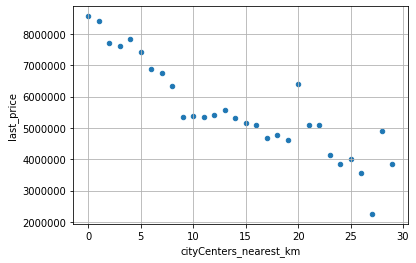

In [72]:
#Построим график, который показывает как цена зависит от удалённости от центра:

(
pd.DataFrame(spb_prices.pivot_table(index='cityCenters_nearest_km', values='last_price').to_records())
    .plot(x='cityCenters_nearest_km', y='last_price', kind='scatter', grid=True)
)
plt.show()

Определим границу, где график сильно меняется — это и будет центральная зона. В нашем случае это 7 км

Выделим  квартиры в центре.

In [73]:
apartments_in_center = pd.DataFrame(spb_prices.query('cityCenters_nearest_km <= 7'))
len(apartments_in_center)

2489

        Проанализируем эти 2 503 объектов недвижимости. Для начала изучим параметры.

In [74]:
# площадь
apartments_in_center.query(total_area_query)['total_area'].describe()

count    2388.00000
mean       64.69361
std        21.11727
min        13.00000
25%        47.10000
50%        63.10000
75%        80.00000
max       115.00000
Name: total_area, dtype: float64

In [75]:
# цена
apartments_in_center['last_price'].describe()

count    2.489000e+03
mean     7.504832e+06
std      2.258508e+06
min      1.600000e+06
25%      5.800000e+06
50%      7.400000e+06
75%      9.150000e+06
max      1.200000e+07
Name: last_price, dtype: float64

In [76]:
# число комнат
apartments_in_center.query(rooms_query)['rooms'].describe()

count    2474.000000
mean        2.376718
std         1.037684
min         1.000000
25%         2.000000
50%         2.000000
75%         3.000000
max         6.000000
Name: rooms, dtype: float64

In [77]:
# высота потолков
apartments_in_center.query(ceiling_height_query)['ceiling_height'].describe()

count    1251.000000
mean        2.876603
std         0.214403
min         2.400000
25%         2.700000
50%         2.900000
75%         3.000000
max         3.200000
Name: ceiling_height, dtype: float64

Средняя площадь 63 кв.м.

Средняя цена 7.5 млн. руб

Больше объявлений по двушкам и трешкам

Средняя высота потолков ~2.9 м.

                                    Выделим факторы, влияющие на стоимость квартиры

In [78]:
# Ранее мы уже сделали срез по квартирам в центре Питера с учетом границы нормального размаха цены.
# Добавим остальные критерии, влияющие на чистоту данных, и сделаем окончательный срез на их основе.
clean_data_query = f'{total_area_query} and {rooms_query} and {ceiling_height_query} and {days_exposition_query}'
clean_data = apartments_in_center.query(clean_data_query)

features = [
    'last_price',
    'cityCenters_nearest_km',
    'total_area',
    'rooms',
    'ceiling_height',
    'day_exposition',
    'month_exposition',
    'year_exposition'
]

clean_data[features].corr().sort_values('last_price', ascending=False)

,last_price,cityCenters_nearest_km,total_area,rooms,ceiling_height,day_exposition,month_exposition,year_exposition
last_price,1.000000,-0.197869,0.700683,0.472800,0.241426,-0.031104,-0.004363,0.037751
total_area,0.700683,-0.226614,1.000000,0.805038,0.303124,-0.063776,0.018168,-0.068860
rooms,0.472800,-0.194752,0.805038,1.000000,0.230564,-0.049550,0.030233,-0.027245
ceiling_height,0.241426,-0.280729,0.303124,0.230564,1.000000,-0.016968,-0.051826,-0.034926
year_exposition,0.037751,0.066048,-0.068860,-0.027245,-0.034926,0.053872,-0.367364,1.000000
month_exposition,-0.004363,-0.037637,0.018168,0.030233,-0.051826,0.017639,1.000000,-0.367364
day_exposition,-0.031104,0.032317,-0.063776,-0.049550,-0.016968,1.000000,0.017639,0.053872
cityCenters_nearest_km,-0.197869,1.000000,-0.226614,-0.194752,-0.280729,0.032317,-0.037637,0.066048


In [79]:
# этаж
clean_data.pivot_table(index='floor', values='last_price').sort_values(by='last_price')

,last_price
floor,
первый,6.435883e+06
последний,7.345157e+06
другой,7.412973e+06


Как и в случае с недвижимостью по всем населенным пунктам, в Петербурге все также самый дешевый этаж – это первый, а самые дорогие – между первым и последним

(25000, 210000)

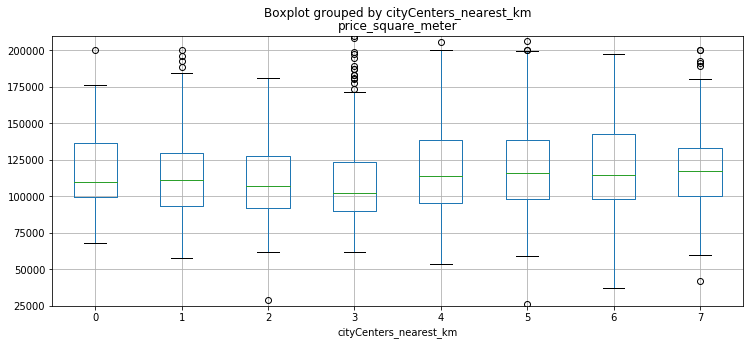

In [80]:
apartments_in_center = pd.DataFrame(spb_prices.query('cityCenters_nearest_km <= 7'))
apartments_in_center.boxplot('price_square_meter', by='cityCenters_nearest_km',figsize=(12,5)) .set_ylim(25000,210000)
#apartments_in_center.describe()
#len(apartments_in_center)


In [81]:
apartments_in_center.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,kitchen_area,balcony,airports_nearest,...,ponds_around3000,ponds_nearest,days_exposition,price_square_meter,day_exposition,month_exposition,year_exposition,living_total_areas_ration,kitchen_total_areas_ration,cityCenters_nearest_km
count,2489.000000,2.489000e+03,2489.000000,2489.000000,1596.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,...,2489.000000,1765.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000,2489.000000
mean,9.661310,7.504832e+06,67.474146,2.365207,3.043929,7.039775,39.619182,11.397302,0.275613,24299.784652,...,1.232222,479.174504,209.823222,117049.234334,2.544797,6.494174,2017.203696,0.576530,0.180246,4.290076
std,5.607381,2.258508e+06,24.935620,1.053822,1.001107,3.934096,18.064479,4.882689,0.662782,4359.111934,...,1.069110,267.592983,247.130578,30266.722039,1.719855,3.435099,1.084405,0.106159,0.075634,1.738139
min,0.000000,1.600000e+06,13.000000,0.000000,2.400000,1.000000,2.000000,2.000000,0.000000,12430.000000,...,0.000000,22.000000,3.000000,15345.268542,0.000000,1.000000,2014.000000,0.038462,0.054348,0.000000
25%,5.000000,5.800000e+06,48.000000,2.000000,2.750000,5.000000,26.700000,8.000000,0.000000,21277.000000,...,0.000000,247.000000,60.000000,95161.290323,1.000000,3.000000,2017.000000,0.520588,0.127389,3.000000
50%,9.000000,7.400000e+06,64.500000,2.000000,3.000000,5.000000,36.700000,10.100000,0.000000,23964.000000,...,1.000000,470.000000,96.000000,112436.115843,3.000000,6.000000,2017.000000,0.583333,0.166667,4.000000
75%,14.000000,9.150000e+06,82.200000,3.000000,3.200000,9.000000,50.100000,13.489541,0.000000,27179.000000,...,2.000000,680.000000,265.000000,134975.369458,4.000000,10.000000,2018.000000,0.653061,0.205696,6.000000
max,32.000000,1.200000e+07,206.000000,7.000000,32.000000,27.000000,160.000000,48.300000,5.000000,39763.000000,...,3.000000,1199.000000,1497.000000,387096.774194,6.000000,12.000000,2019.000000,0.901675,0.625000,7.000000


(40000, 185000)

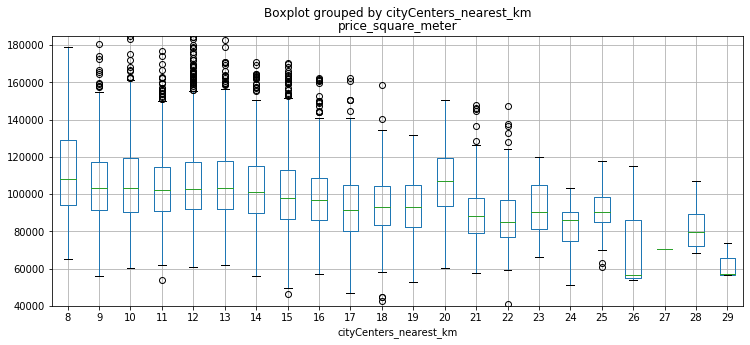

In [84]:
saint_petersburg = pd.DataFrame(realty.loc[realty['locality_name'] == "Санкт-Петербург"])
saint_petersburg.reset_index()

apartments_not_in_center = pd.DataFrame(spb_prices.query('cityCenters_nearest_km > 7'))
apartments_not_in_center.boxplot('price_square_meter', by='cityCenters_nearest_km',figsize=(12,5)) .set_ylim(40000,185000)


In [88]:
#Делаем таблицу корреляции тем что ближе 7 км
cor_in_center = apartments_in_center.corr()\
        .sort_values('last_price', ascending=False)\
        .filter(items = ['last_price'])\
        .reset_index()
#Вторую, тем что дальше 7 км
cor_out_center = apartments_not_in_center.corr()\
        .sort_values('last_price', ascending=False)\
        .filter(items = ['last_price'])\
        .reset_index()

#Склейка
cor_in_out_center = cor_in_center.merge(cor_out_center, on='index')
#Ииии
cor_in_out_center

,index,last_price_x,last_price_y
0,last_price,1.000000,1.000000
1,total_area,0.696149,0.806438
2,living_area,0.598695,0.662093
3,rooms,0.493575,0.500985
4,kitchen_area,0.458195,0.571799
5,price_square_meter,0.178296,0.384063
6,days_exposition,0.131616,0.047678
7,ceiling_height,0.113228,0.072100
8,total_images,0.087947,0.175374
9,parks_around3000,0.062277,0.033808


В центре имеет вес:

- Цена за квадрат
- Все виды площадей
- Количество комнат
- Площади


А там что подальше:

- Площади
- Количество комнат
- Цена за квадрат
- Балконы
- Этаж

Что в центре, что на перефирии сильно влияют на цену площади(жилые, кухня, общая), цена за квадратный метр, количество комнат.

### Шаг 5. Общий вывод

1.Недвижимость в центре Петербурга ожидаемо стоит дороже остальных населенных пунктов.

Но не всегда, видимо, присутствуют коттеджные поселки или элитная недвижимость.

2.Датасет с выбросами и датасет без выбросов дает примерно один и тот же результат, применительно к текущим задачам один: вряд 

ли важно цена за квадрат 90 или 95 тысяч, это ни на что не влияет.

3.Ближе к центру города дороже. Однако в пределах центра стоимость +/- однинаковая.

4.Факторы, влияющие на стоимость:
- общая площадь
- кол-во комнат
- высота потолков
- жилая площадь
- количество эажей в доме



Стоит порекомендовать площадке на которой собранны данные:

- Уделить внимание правилам валидации на сервере, чтобы больше не сталкиваться с проблемой отсутствующих значений.
- Продумать сценарий, при котором данные до парков, водоемов, аэропортов будут подтягиваться автоматически.
- Считать расстояние в километрах и целых числах.
